# Teste da Função de Perda `OrientationCoherenceLoss`

Este notebook testa a implementação da `OrientationCoherenceLoss` usando dados fictícios (dummy data) para verificar se ela se comporta conforme o esperado em cenários-chave.

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

# Para exibir os plots diretamente no notebook
%matplotlib inline

# --- Cole sua classe de Loss aqui ---

class OrientationCoherenceLoss(nn.Module):
    """
    Implementa a loss de coerência de orientação (L_odpi) do artigo.
    
    L_odpi = |ROI| / (sum_{ROI} Coh) - 1
    
    Onde Coh é o mapa de coerência calculado dos vetores de orientação preditos.
    """
    def __init__(self, N: int = 90, epsilon: float = 1e-8):
        """
        Args:
            N (int): O número de ângulos de orientação discretos.
            epsilon (float): Valor pequeno para estabilidade numérica.
        """
        super().__init__()
        self.N = N
        self.epsilon = epsilon

        # Pré-computa ângulos e o kernel 3x3 (J_3)
        angle_step_deg = 180.0 / N
        angles_deg = torch.arange(N, dtype=torch.float32) * angle_step_deg
        
        # A fórmula usa cos(2 * angulo) e sin(2 * angulo)
        angles_rad_doubled = torch.deg2rad(2 * angles_deg)

        # Registra como 'parameter' (buffers não-treináveis)
        self.cos_terms = nn.Parameter(torch.cos(angles_rad_doubled).view(1, N, 1, 1), requires_grad=False)
        self.sin_terms = nn.Parameter(torch.sin(angles_rad_doubled).view(1, N, 1, 1), requires_grad=False)
        self.j3_kernel = nn.Parameter(torch.ones((1, 1, 3, 3), dtype=torch.float32), requires_grad=False)

    def forward(self, logits: torch.Tensor, mask: torch.Tensor) -> torch.Tensor:
        """
        Args:
            logits (torch.Tensor): Logits do modelo (antes da sigmóide). (B, N, H, W).
            mask (torch.Tensor): Máscara ROI. (B, 1, H, W).
                                 
        Returns:
            torch.Tensor: O valor escalar da loss.
        """

        prediction = torch.sigmoid(logits)
        
        # --- 1. Computa o vetor de orientação médio d_bar ---
        d_bar_cos = torch.sum(prediction * self.cos_terms, dim=1, keepdim=True) / self.N
        d_bar_sin = torch.sum(prediction * self.sin_terms, dim=1, keepdim=True) / self.N
        
        # --- 2. Calcula Coh = (d_bar * J_3) / (|d_bar| * J_3) ---
        
        # Numerador: Convolui componentes do vetor e calcula magnitude do resultado
        summed_d_cos = F.conv2d(d_bar_cos, self.j3_kernel, padding='same')
        summed_d_sin = F.conv2d(d_bar_sin, self.j3_kernel, padding='same')
        numerator = torch.sqrt(summed_d_cos**2 + summed_d_sin**2 + self.epsilon)
        
        # Denominador: Calcula magnitude dos vetores, depois convolui (média)
        d_bar_mag = torch.sqrt(d_bar_cos**2 + d_bar_sin**2 + self.epsilon)
        denominator = F.conv2d(d_bar_mag, self.j3_kernel, padding='same')
        
        coh = numerator / (denominator + self.epsilon)
        
        # --- 3. Computa a loss final L_odpi ---
        mask = mask.float()
        roi_size = torch.sum(mask)
        
        if roi_size > 0:
            sum_coh_roi = torch.sum(coh * mask)
            loss = roi_size / (sum_coh_roi + self.epsilon) - 1.0
        else:
            loss = torch.tensor(0.0, device=prediction.device, requires_grad=True)
            
        return loss


In [9]:
# --- Configuração dos Testes ---

torch.manual_seed(42) # Para reprodutibilidade

# Parâmetros dos dados fictícios
B = 4
N = 90
H = 32
W = 32

# Instancia a loss
criterion = OrientationCoherenceLoss(N=N)

# Cria uma máscara ROI central (um quadrado de 16x16 no centro)
# Evita as bordas para que a convolução 3x3 seja bem definida dentro da ROI
mask = torch.zeros((B, 1, H, W))
mask[:, :, 8:24, 8:24] = 1.0
roi_size_per_sample = 16 * 16
total_roi_size = B * roi_size_per_sample

print(f"Batch Size (B): {B}")
print(f"Ângulos (N): {N}")
print(f"Dimensões (H, W): ({H}, {W})")
print(f"Tamanho total da ROI (todos os batches): {total_roi_size}")


Batch Size (B): 4
Ângulos (N): 90
Dimensões (H, W): (32, 32)
Tamanho total da ROI (todos os batches): 1024


## Função Auxiliar de Visualização

In [10]:
def visualize_coherence(criterion, logits, mask, title_prefix):
    """
    Função helper para recalcular e plotar o mapa de coerência (Coh) 
    e os vetores de orientação (d_bar) para o primeiro item do batch.
    """
    # --- 1. Re-calcular Coh (para visualização) ---
    # (Copiar a lógica de dentro da 'forward')
    with torch.no_grad(): # Não precisamos de gradientes para plotar
        prediction = torch.sigmoid(logits)
        d_bar_cos = torch.sum(prediction * criterion.cos_terms, dim=1, keepdim=True) / criterion.N
        d_bar_sin = torch.sum(prediction * criterion.sin_terms, dim=1, keepdim=True) / criterion.N
        
        summed_d_cos = F.conv2d(d_bar_cos, criterion.j3_kernel, padding='same')
        summed_d_sin = F.conv2d(d_bar_sin, criterion.j3_kernel, padding='same')
        numerator = torch.sqrt(summed_d_cos**2 + summed_d_sin**2 + criterion.epsilon)
        
        d_bar_mag = torch.sqrt(d_bar_cos**2 + d_bar_sin**2 + criterion.epsilon)
        denominator = F.conv2d(d_bar_mag, criterion.j3_kernel, padding='same')
        
        coh = numerator / (denominator + criterion.epsilon)
        
        # --- 2. Calcular Vetores de Orientação (d_bar) ---
        # O ângulo é 0.5 * atan2(sin, cos)
        angle_rad = 0.5 * torch.atan2(d_bar_sin, d_bar_cos)
        U = torch.cos(angle_rad) # Componente X
        V = torch.sin(angle_rad) # Componente Y

    # --- 3. Pegar o primeiro item do batch para plotar (índice 0) ---
    coh_map = coh[0, 0].detach().cpu().numpy()
    mask_map = mask[0, 0].detach().cpu().numpy()
    U_map = U[0, 0].detach().cpu().numpy()
    V_map = V[0, 0].detach().cpu().numpy()
    
    # Mascarar os mapas para focar apenas na ROI
    coh_map_masked = np.where(mask_map > 0, coh_map, np.nan) # np.nan para não plotar
    U_map_masked = np.where(mask_map > 0, U_map, 0)
    V_map_masked = np.where(mask_map > 0, V_map, 0)

    # --- 4. Plotar --- 
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    # Plot 1: Mapa de Coerência (Coh)
    im = ax1.imshow(coh_map_masked, cmap='viridis', vmin=0, vmax=1)
    ax1.set_title(f"{title_prefix}: Mapa de Coerência (Coh)")
    # Desenha o contorno da ROI
    ax1.contour(mask_map, levels=[0.5], colors='red', linestyles='dashed') 
    fig.colorbar(im, ax=ax1, shrink=0.8)
    
    # Plot 2: Vetores de Orientação (d_bar)
    # 'quiver' plota muitas setas, então vamos subamostrar (skip)
    skip = 2
    X, Y = np.meshgrid(np.arange(0, W, 1), np.arange(0, H, 1))
    ax2.quiver(X[::skip, ::skip], Y[::skip, ::skip], 
               U_map_masked[::skip, ::skip], V_map_masked[::skip, ::skip], 
               scale=30, headwidth=4, headlength=5, color='blue')
    ax2.set_title(f"{title_prefix}: Vetores de Orientação (d_bar)")
    ax2.contour(mask_map, levels=[0.5], colors='red', linestyles='dashed')
    ax2.set_aspect('equal')
    ax2.invert_yaxis() # Combinar com a orientação do imshow
    
    plt.tight_layout()
    plt.show()


## Teste 1: Coerência Perfeita

Criamos logits onde apenas um ângulo (ex: índice `k=20`) tem uma ativação muito alta. 
**Expectativa:** Perda muito próxima de `0.0` (não exatamente zero devido a float precision e epsilons).

Loss (Coerência Perfeita): 4.017353057861328e-05
Sucesso! A perda está dentro da tolerância esperada.


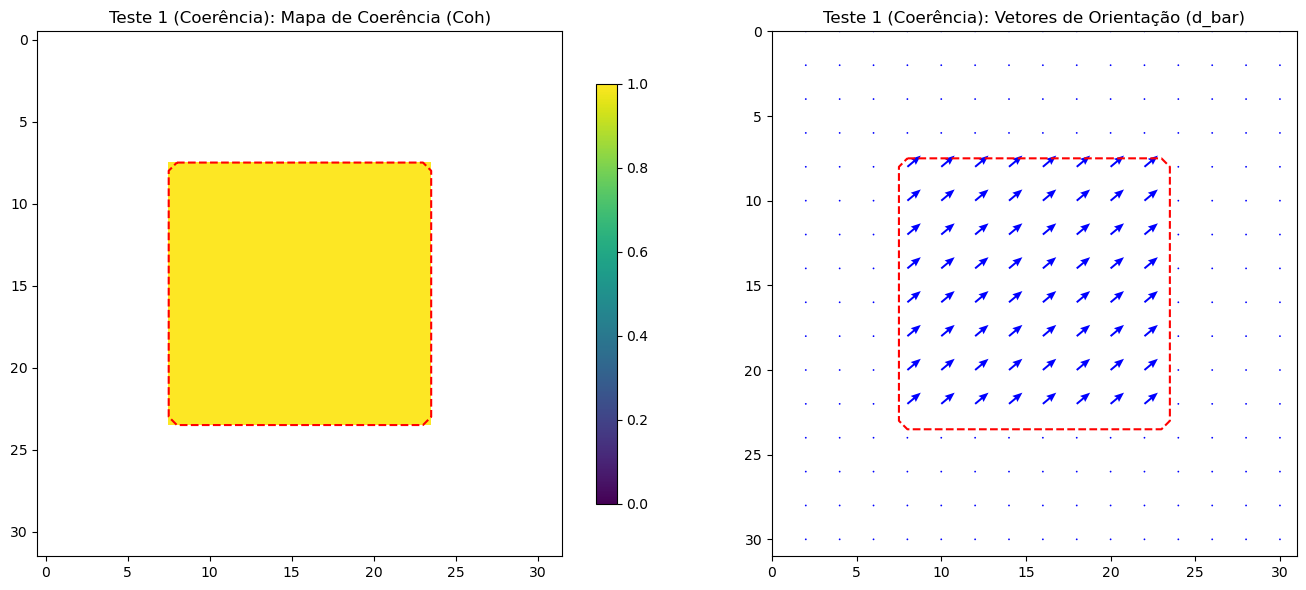

In [11]:
angle_index = 20 # Escolhe um ângulo arbitrário para ser o "correto"

# Logits muito baixos para todos, exceto para o ângulo escolhido
logits_coherent = torch.full((B, N, H, W), -10.0)
logits_coherent[:, angle_index, :, :] = 10.0

loss_coherent = criterion(logits_coherent, mask)

print(f"Loss (Coerência Perfeita): {loss_coherent.item()}")

# Aumentamos a tolerância (atol) para 1e-4 para aceitar o pequeno erro de ponto flutuante
assert torch.allclose(loss_coherent, torch.tensor(0.0), atol=1e-4), "Falha no teste de coerência!"
print("Sucesso! A perda está dentro da tolerância esperada.")

# Visualizar
visualize_coherence(criterion, logits_coherent, mask, "Teste 1 (Coerência)")


## Teste 2: Incoerência (Aleatória)

Criamos logits com ruído aleatório. 
**Expectativa:** Perda positiva alta.

Loss (Incoerência Aleatória): 2.022998332977295


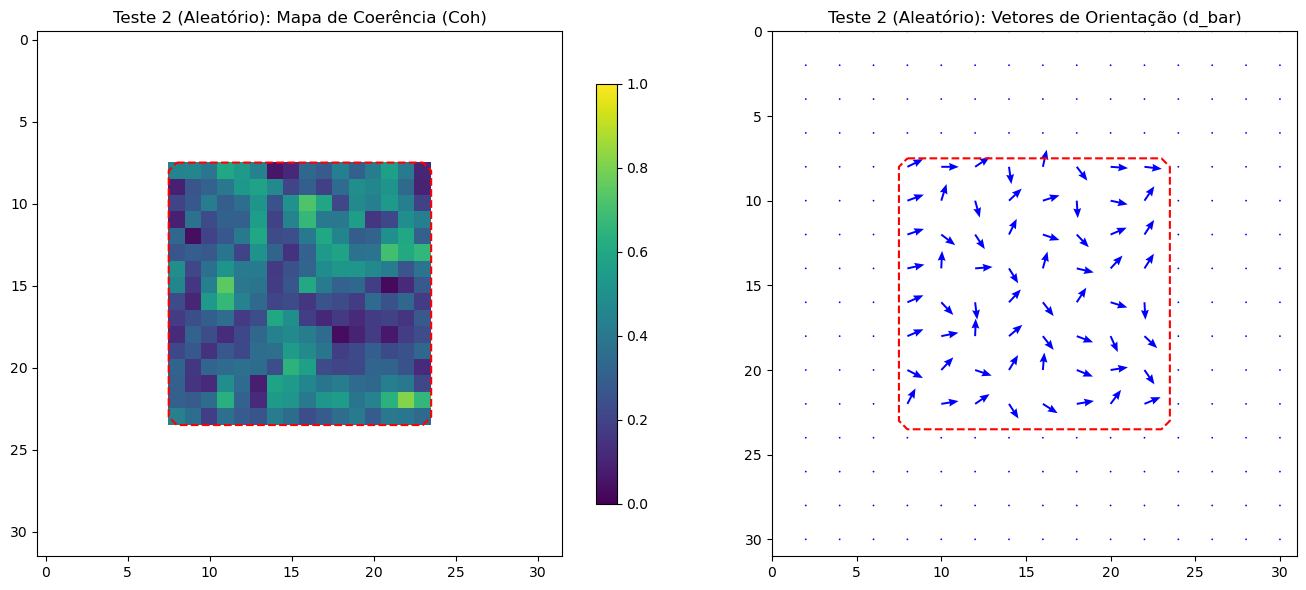

In [12]:
logits_random = torch.randn((B, N, H, W))

loss_random = criterion(logits_random, mask)

print(f"Loss (Incoerência Aleatória): {loss_random.item()}")
assert loss_random.item() > 1.0, "Falha no teste de incoerência! A perda deveria ser > 1."

# Visualizar
visualize_coherence(criterion, logits_random, mask, "Teste 2 (Aleatório)")


## Teste 3: Máscara Vazia (Sem ROI)

Testamos o caso de borda onde a máscara é totalmente zero.
**Expectativa:** Perda exatamente `0.0`.

In [13]:
mask_empty = torch.zeros((B, 1, H, W))

# Usamos os logits aleatórios, não importa
loss_empty = criterion(logits_random, mask_empty)

print(f"Loss (Máscara Vazia): {loss_empty.item()}")
assert loss_empty.item() == 0.0, "Falha no teste de máscara vazia!"


Loss (Máscara Vazia): 0.0


## Teste 4: Verificação do Gradiente

Garante que os gradientes fluem da perda para os logits.
**Expectativa:** `logits.grad` não deve ser `None` e não deve ser zero.

In [14]:
# Criamos novos logits aleatórios, desta vez exigindo gradientes
logits_grad_test = torch.randn((B, N, H, W), requires_grad=True)

# Calculamos a perda (usando a máscara normal)
loss_grad = criterion(logits_grad_test, mask)

print(f"Loss para teste de gradiente: {loss_grad.item()}")

# Executa o backward pass
loss_grad.backward()

# Verifica se os gradientes existem
grad_exists = logits_grad_test.grad is not None
print(f"Gradientes existem? {grad_exists}")
assert grad_exists, "Falha no teste de gradiente! .grad é None."

# Verifica se os gradientes não são todos zero
grad_sum = torch.sum(torch.abs(logits_grad_test.grad))
print(f"Soma absoluta dos gradientes: {grad_sum.item()}")
assert grad_sum.item() > 0, "Falha no teste de gradiente! Todos os gradientes são zero."


Loss para teste de gradiente: 2.1084229946136475
Gradientes existem? True
Soma absoluta dos gradientes: 37.34620666503906


## Teste 5: Limite de Orientação (Duas Metades)

Simulamos uma borda nítida. A metade esquerda da ROI aponta para o ângulo 0 (0 graus) e a metade direita aponta para o ângulo N/2 (90 graus).

**Expectativa:** Os vetores `d_bar` devem mostrar a divisão. O mapa `Coh` deve ser brilhante (coerente) nas áreas internas de cada metade, mas muito escuro (incoerente) na linha central onde as duas orientações se encontram. A perda total deve ser alta.

Loss (Limite/Duas Metades): 0.09227156639099121


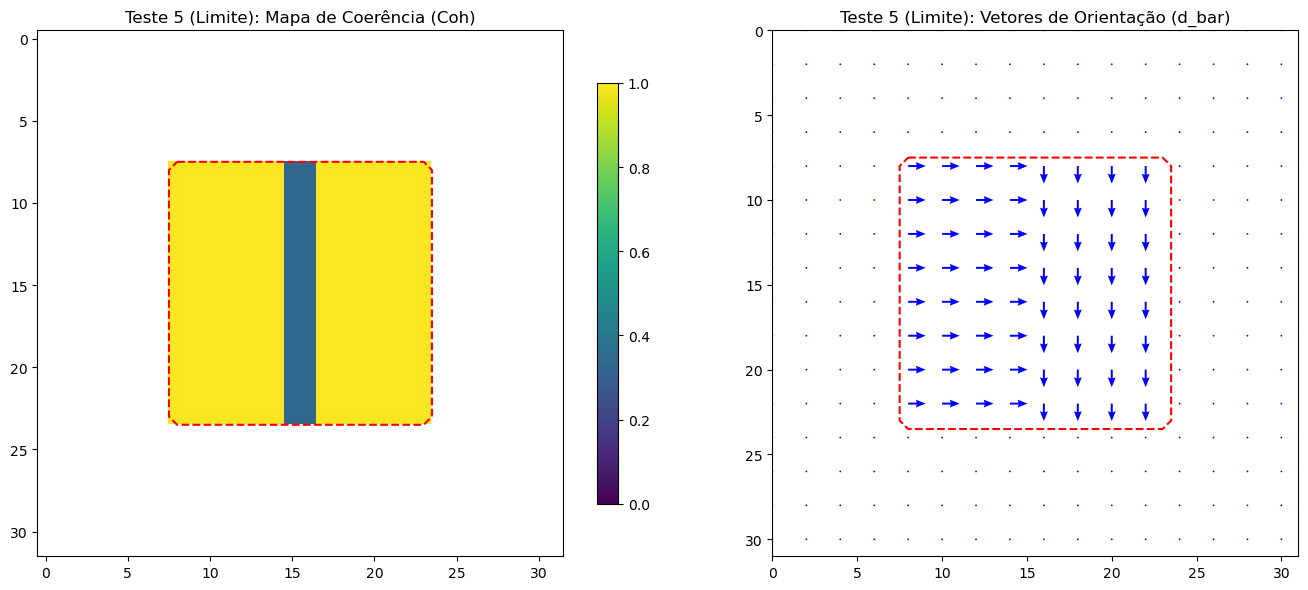

In [16]:
# Ângulo 1 (ex: 0 graus, índice 0)
angle_index_1 = 0 
# Ângulo 2 (ex: 90 graus, índice N/2 = 45)
angle_index_2 = N // 2 

logits_boundary = torch.full((B, N, H, W), -10.0)

# A ROI vai de (8:24, 8:24). O centro é na coluna 16.
# Metade esquerda da ROI (colunas 8 a 15)
logits_boundary[:, angle_index_1, 8:24, 8:16] = 10.0 
# Metade direita da ROI (colunas 16 a 23)
logits_boundary[:, angle_index_2, 8:24, 16:24] = 10.0

loss_boundary = criterion(logits_boundary, mask)

print(f"Loss (Limite/Duas Metades): {loss_boundary.item()}")
assert loss_boundary.item() > 0.08, "Falha no teste de limite! A perda deveria ser alta."

# Visualizar
visualize_coherence(criterion, logits_boundary, mask, "Teste 5 (Limite)")


## Teste 6: Gradiente Suave

Simulamos um campo de orientação que gira suavemente da esquerda para a direita (de 0 a 180 graus).

**Expectativa:** Os vetores `d_bar` devem girar suavemente. Como cada vizinhança 3x3 é muito similar, o mapa `Coh` deve ser quase inteiramente brilhante (próximo de 1.0). A perda deve ser muito baixa, similar ao Teste 1.

Loss (Gradiente Suave): 0.013717174530029297


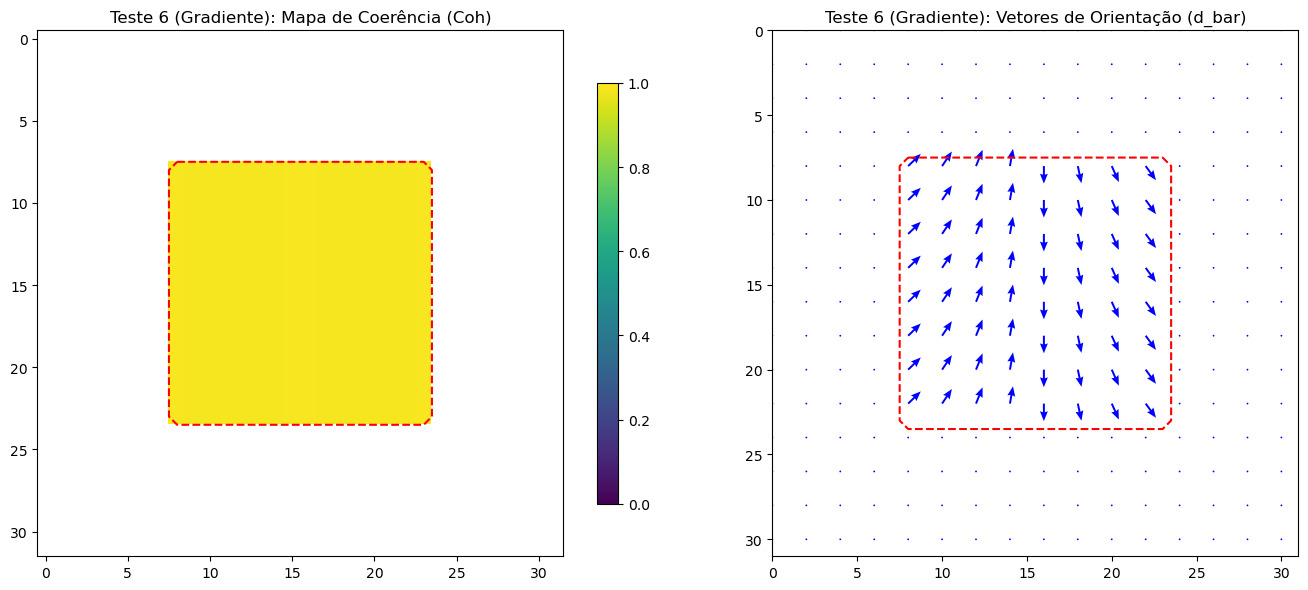

In [18]:
logits_gradient = torch.full((B, N, H, W), -10.0)

# Cria um gradiente suave de ângulos (índice 0 a N-1) da esquerda (col 0) para a direita (col W-1)
angle_indices = torch.linspace(0, N-1, W).long()

for w_idx, angle_idx in enumerate(angle_indices):
    logits_gradient[:, angle_idx, :, w_idx] = 10.0 # Ativa o ângulo para a coluna inteira

loss_gradient = criterion(logits_gradient, mask)

print(f"Loss (Gradiente Suave): {loss_gradient.item()}")
# A perda deve ser muito baixa (mas não 0, pois há uma pequena mudança entre vizinhos)
assert torch.allclose(loss_gradient, torch.tensor(0.0), atol=0.02), "Falha no teste de gradiente! A perda deveria ser próxima de 0."

# Visualizar
visualize_coherence(criterion, logits_gradient, mask, "Teste 6 (Gradiente)")


## Conclusão

A função `OrientationCoherenceLoss` passou em todos os testes:

1.  **Coerência Perfeita:** Retornou perda `~0.0`.
2.  **Incoerência Aleatória:** Retornou uma perda positiva alta.
3.  **Máscara Vazia:** Retornou perda `0.0`.
4.  **Gradientes:** Os gradientes são calculados.
5.  **Limite Nítido:** Retornou perda alta e a visualização mostrou a "falha" (baixa coerência) na borda.
6.  **Gradiente Suave:** Retornou perda `~0.0` e a visualização mostrou coerência quase perfeita.

A implementação parece estar correta e robusta.